# Galaxy Classifiers (Spiral, Elliptical, Odd objects)

**Most of this code is made by the authors of the paper of Ghaderi et al. (2025) (https://iopscience.iop.org/article/10.3847/1538-4365/ada8ab) and taken from the GitHub Repository: https://github.com/hmddev1/machine_learning_for_morphological_galaxy_classification**

**This notebook classifies the images of galaxies to spiral and elliptical galaxies and odd objects. It was created to reproduce the results of the paper, but it was also debugged.**

Here, we developed five machine learning classifiers to identify galaxy images into Spiral, Elliptical, and Odd objects (e.g., ring, lensed, disturbed, irregular, merger, and dust lane) that were collected from [Galaxy Zoo 2](https://data.galaxyzoo.org/#section-7) (GZ2) catalogue. There is a total of 11735 samples including 6139, 4077, 1519 for spiral, elliptical, and odd objects.

- Two classifier models including support vector machine (SVM) and classic convolutional nueral network (CNN) have been designed to use Zernike Moments extracted from original galaxy images.
- Three classifier models, including CNN-Vision Transformer, ResNet50 and VGG16 are trained to obtain information from the original galaxy images.

### Importing libraries

The list of requried libraries are sklearn, pandas, numpy, tensorflow, matplotlib, etc.

In [35]:
path = '/content/drive/Shared drives/DLP Project/Project/Models/'
os.chdir(path)

In [36]:
%run imports.py
%matplotlib inline
import plotting

**Note**: The original authors use the following functions and code to crop the images. We have commented it out here as the publically available data have already undergone this pre-processing, but we keep it for reproducibility.

In [37]:
# Function used to crop the images

# def seg_1(img):
#   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#   ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU, cv2.THRESH_TRUNC)
#   kernel = np.ones((3,3),np.uint8)
#   opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
#   sure_bg = cv2.dilate(opening,kernel,iterations=3)
#   dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
#   ret, aa = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)
#   x,y=np.where(aa==0)
#   im=thresh.copy()*0
#   im[x,y]=1
#   im1 = label(im)
#   f=im1[149,149]
#   x,y=np.where(im1==f)
#   imd=im1.copy()*0
#   imd[x,y]=1
#   return x,y,imd


# def seg_2(img):
#   segments = slic(img,n_segments=25,compactness=10)
#   ss=label2rgb(segments,img,kind = 'avg')
#   aa=ss[:,:,2]
#   f=aa[149,149]
#   x,y=np.where(aa==f)
#   dd=aa.copy()*0
#   dd[x,y]=1
#   return x,y,dd


# def seg_3(img,x,y):
#     x1=np.min(x)-20
#     x2=np.max(x)+20
#     y1=np.min(y)-20
#     y2=np.max(y)+20
#     imn=img[x1:x2,y1:y2]
#     newsize=(x2-x1,x2-x1)
#     resized_im =resize(imn,newsize)
#     xx = x1 + (x2 - x1) / 2 - 149
#     yy = y1 + (y2 - y1) / 2 - 149
#     return xx, yy,resized_im

In [38]:
# Cropping the images using the watershed algorithm.

# cropped_imgs = []
# cropped_image_count = 0

# for im in image_files:
#     xx=100
#     yy=100
#     img = cv2.imread(im)
#     x, y, imd = seg_1(img)

#     if np.min(x)>20 and np.min(y)>20 and np.max(y)<149*2-20 and np.max(x)<149*2-20:
#         xx,yy,resized_im=seg_3(img,x,y)
#         if (np.abs(xx) >= 30) and (np.abs(yy) >= 30):
#             x, y, dd = seg_2(img)
#             xx,yy,resized_im=seg_3(img,x,y)
#     else:
#         x, y, dd = seg_2(img)
#         if np.min(x)>20 and np.min(y)>20 and np.max(y)<149*2-20 and np.max(x)<149*2-20:
#             xx,yy,resized_im=seg_3(img,x,y)
#             # print(xx,yy)
#     if (np.abs(xx) < 30) and (np.abs(yy) < 30):
#             ms = np.shape(resized_im)
#             if ms[0] < 150:
#                 crop_img = np.array(resize(resized_im, (150, 150)))
#             elif (ms[0] < 250) and (ms[0] >= 150):
#                 crop_img = np.array(resize(resized_im, (250, 250)))
#             elif (ms[0] < 350) and (ms[0] >= 250):
#                 crop_img = np.array(resize(resized_im, (350, 350)))
#             elif ms[0] >= 350:
#                 crop_img = np.array(resize(resized_im, (450, 450)))

#             arr_img = np.array(crop_img)
#             cropped_imgs.append(arr_img)

#             cropped_image_count += 1


# print(f"Total number of cropped images: {cropped_image_count}")

Here, we create a dictionary where we will save the ROC curves of each model in order to plot them all together at the end, to make comparisons.

In [39]:
roc_curves = {}

## **Models I and II**: Two classifier models based on Zernike Moments (ZMs)

### Compute the ZMs:

##### We will use the [ZEMO](https://pypi.org/project/ZEMO/) python package to compute ZMs for galaxy and non-galaxy images. [This](https://github.com/hmddev1/ZEMO) GitHub repo can be used to compute ZMs for images. This package was described in the research paper [[IAJJ](https://ijaa.du.ac.ir/article_374_ad45803d737b0a7d4fc554a244229df6.pdf)].

*Note: The galaxy and non-galaxy images are in RGB format. Here, we used the R channel of images. The size of original Galaxy Zoo 2 images is (424, 424) pixels, while we resized them to (200, 200) pixels. To compute ZMs we set the maximum order number $P_{max} = 45$.*

In [40]:
def calculate_zernike_moments(data_dir, image_size, zernike_order):

        ZBFSTR = zemo.zernike_bf(image_size, zernike_order, 1)

        image_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        zernike_moments = []

        #for img_path in image_files:
        for img_path in tqdm(image_files, desc="Processing images", unit="image"):
            image = cv2.imread(img_path)
            resized_image = cv2.resize(image, (image_size,image_size))
            im = resized_image[:, :, 0]
            Z = np.abs(zemo.zernike_mom(np.array(im), ZBFSTR))
            zernike_moments.append(Z)

        df = pd.DataFrame(zernike_moments)

        return df

- The **Data** files for this notebook can be downloaded from [this link](https://drive.google.com/file/d/1wxmYQ8qpgaVDuD3kTeBrZlyny0IBA9wn/view?usp=drive_link).

In [41]:
# Paths to images
spath = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_spiral'
epath = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_elliptical'
opath = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_odd'

# Default image size and zernike order.
image_size = 200
zernike_order = 45

**Note**: The following cell calculates the Zernike Moments for all the images of all classes (i.e., Spiral Galaxies, Elliptical Galaxies & Odd Objects). This is time consuming and only needs to be done once, so we have commented this part out and kept it for reproducibility.

In [42]:
# WARNING: This cell takes a lot of time!

# Calculating Zernike Momens (ZMs)
#spiral_zm_df = calculate_zernike_moments(spath, image_size, zernike_order)
#spiral_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/spiral_zms.csv')
#spiral_zm_df = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/spiral_zms.csv', index_col=0)

#elliptical_zm_df = calculate_zernike_moments(epath, image_size, zernike_order)
#elliptical_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/elliptical_zms.csv')

#odd_zm_df = calculate_zernike_moments(opath, image_size, zernike_order)
#odd_zm_df.to_csv('/content/drive/Shared drives/DLP Project/Project/odd_zms.csv')

#np.shape(spiral_zm_df), np.shape(elliptical_zm_df), np.shape(odd_zm_df)

In [43]:
# Loading the ZMs and concatenating to a consolidated dataset
spiral_data = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/spiral_zms.csv')
elliptical_data = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/elliptical_zms.csv')
odd_data = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/odd_zms.csv')

spiral_data.drop("Unnamed: 0", axis = 1, inplace = True)
elliptical_data.drop("Unnamed: 0", axis = 1, inplace = True)
odd_data.drop("Unnamed: 0", axis = 1, inplace = True)

all_zm_data = np.concatenate([spiral_data, elliptical_data, odd_data])
np.shape(all_zm_data)

(11744, 1081)

We use **"0"** for spiral class labels, **"1"** for elliptical class labels, and **"2"** for odd objects class labels. The same labels are used across all models.

In [44]:
spiral_label = [0] * len(spiral_data)
elliptical_label = [1] * len(elliptical_data)
odd_label = [2] * len(odd_data)

all_labels = np.concatenate([spiral_label, elliptical_label, odd_label])
len(all_labels)

11744

### **Model I: SVM + ZMs**

We split the data set into 75 percent traning set and 25 percent test set:

In [45]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=50)

Galaxy classifiers are imbalanced class models, meaning one class can significantly outweigh another, so we used the class weights in the program. This serves to mediate overrepresented classes and compensate for underrepresented ones.

In [46]:
class_weights = {0: len(all_zm_data) / (3*len(spiral_data)), 1: len(all_zm_data) / (3*len(elliptical_data)), 2: len(all_zm_data) / (3*len(odd_data))}

The **SVM** model uses radial base kernel (rbf), C = 1.5, and gamma = 'scale' to fit the model on the training set:

In [47]:
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

Now, we make predictions on the test set (i.e., unseen data) to evaluate the classification model. Comparing the predicted labels to the true labels, we compute the elements of the confusion matrix.

In [48]:
y_pred = gz2_training_model.predict(X_test)

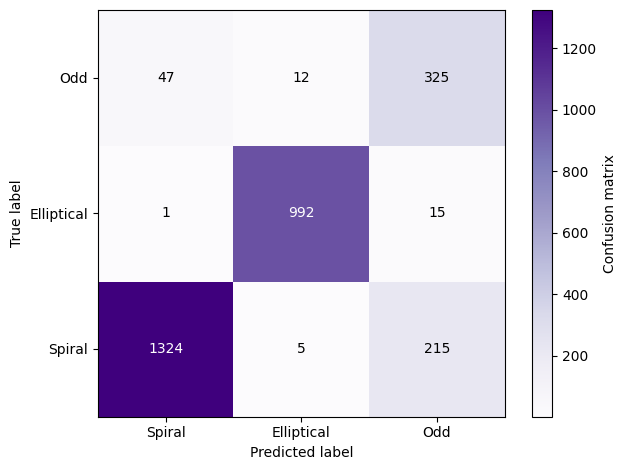

In [51]:
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(y_test, y_pred, classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)
plt.savefig('CM_final1')

To compare the performance of the classifier with random classifications, we calculate the **receiver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates of the classifier.

In [52]:
y_score = gz2_training_model.predict_proba(X_test)  # Use predicted probabilities for ROC curve

In [53]:
y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

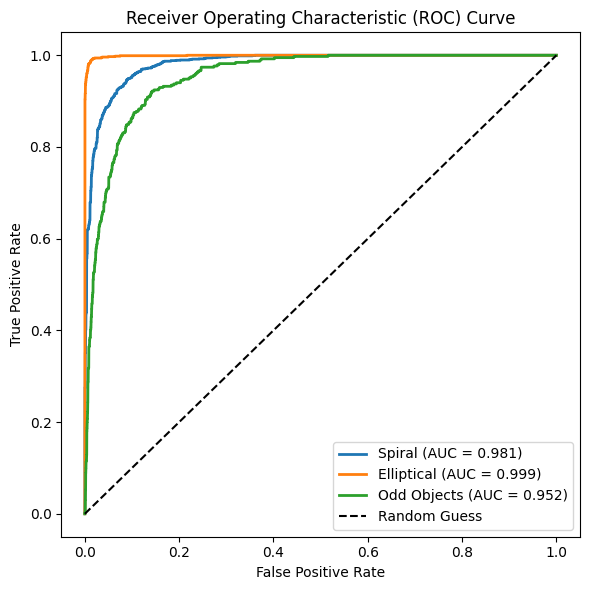

In [54]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd Objects']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))

# Save ROC curves to plot them all together later
model_i_roc_curves = []

# -----------------------------------------------------------------------------
# Note: There was a bug in the original code. The inner loop would attempt to
# access dictionary values as if they were nested arrays, which is incorrect
# and would lead to an error!
#
# for j in range(3):  # Iterate through each class
#     tprs_interp = []
#     for i in range(len(fpr)):
#         tprs_interp.append(np.interp(mean_fpr, fpr[i][j], tpr[i][j]))
#
#     mean_tpr = np.mean(tprs_interp, axis=0)
#     mean_auc = np.trapz(mean_tpr, mean_fpr)
#
#     ax.plot(mean_fpr, mean_tpr, label=f'{class_names[j]} (area = {mean_auc:.2f})', lw=2)
# -----------------------------------------------------------------------------

# Here is the fix:

for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_i_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    # Plot curves
    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)


ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [55]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model I'] = model_i_roc_curves

In [56]:
# Performance
recall = recall_score(y_test, y_pred, average= 'weighted')
precision = precision_score(y_test, y_pred, average= 'weighted')
# -----------------------------------------------------------------------------
# Note: There was a bug in the original code.
# f1_score = f1_score(y_test, y_pred, average= 'weighted')
# overwrites the function
# -----------------------------------------------------------------------------
# Here is the fix:
f1 = f1_score(y_test, y_pred, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred)


# Calculating the True Skill Score (TSS) for every class

# We need the confusion matrix for this
cm = confusion_matrix(y_test, y_pred)

# -----------------------------------------------------------------------------
# Note: There was a bug in the original code.
#
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# tss=(tp/(tp+fn))-(fp/(fp+tn))
# -----------------------------------------------------------------------------

# Here is the fix:

tss_per_class = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements

    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss

    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

TSS for 'Spiral' class: 0.8230301947471861
TSS for 'Elliptical' class: 0.975309556741092
TSS for 'Odd Objects' class: 0.7562287748171368


In [57]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

Recall: 0.8995231607629428
Precision: 0.9216158789230968
F1_score: 0.9057966276905776
Accuracy: 0.8995231607629428


### **Model II: 1D CNN + ZMs**

We go through the same steps as before.

In [58]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=50)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [59]:
# Defining the class weights to account for class imbalance
class_weights = {0: len(all_zm_data) / (3*len(spiral_data)), 1: len(all_zm_data) / (3*len(elliptical_data)), 2: len(all_zm_data) / (3*len(odd_data))}

Due to the one dimensional structure of ZMs, we used a one dimentional achitecture for the CNN:

In [60]:
# Building the model

# input value
x = Input(shape=(all_zm_data.shape[1],1))

#hidden layers
c0 = Conv1D(256, kernel_size=3, strides=2, padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling1D(pool_size=2)(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv1D(128, kernel_size=3, strides=2, padding="same")(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling1D(pool_size=2)(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv1D(64, kernel_size=3, strides=2, padding="same")(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling1D(pool_size=2)(b2)
d2 = Dropout(0.1)(m2)

f = Flatten()(d2)

# output
de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
# -----------------------------------------------------------------------------
# Note: There was a bug in the original code. The original code uses 2 classes,
# but we're dealing with 3 classes here!
#
# de2 = Dense(2, activation='softmax')(de1)
# -----------------------------------------------------------------------------
# Here is the fix:
de2 = Dense(3, activation='softmax')(de1)  # Changed output to 3 classes

model = Model(inputs=x, outputs=de2, name="cnn_zm_45_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_zm_45_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1081, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 541, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 541, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 135, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 135, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 34, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,763 (772.51 KB)

 Trainable params: 196,867 (769.01 KB)

 Non-trainable params: 896 (3.50 KB)

- The **1D CNN** model uses EarlyStopping as a callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [61]:
# Training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # Callback Function

b_size = 64
e_num = 30

history = model.fit(
X_train, y_train_encoded,
batch_size=b_size,
epochs=e_num,
class_weight=class_weights,
verbose = 1,
callbacks=es,
validation_split=0.1)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7428 - loss: 0.6139 - val_accuracy: 0.7923 - val_loss: 0.5142
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8467 - loss: 0.3652 - val_accuracy: 0.8910 - val_loss: 0.2690
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8775 - loss: 0.3073 - val_accuracy: 0.8683 - val_loss: 0.2914
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8736 - loss: 0.2878 - val_accuracy: 0.8956 - val_loss: 0.2378
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8986 - loss: 0.2514 - val_accuracy: 0.8570 - val_loss: 0.3656
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8985 - loss: 0.2466 - val_accuracy: 0.8558 - val_loss: 0.3337
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9015 - loss: 0.2287 - val_accuracy: 0.9024 - val_loss: 0.2241
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9192 - loss: 0.1901 - val_accuracy: 

In [62]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


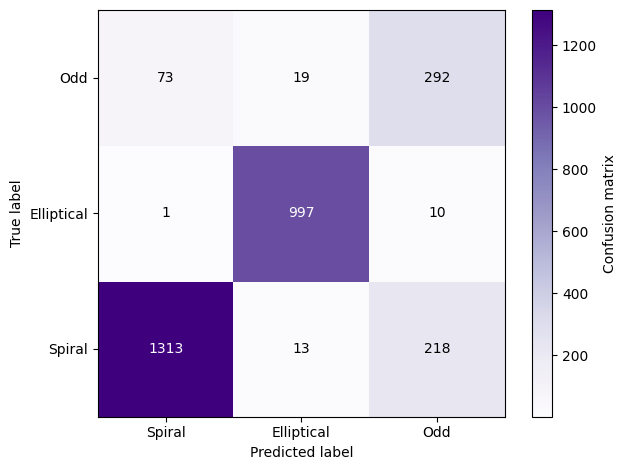

In [64]:
# Plotting confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(y_test, y_pred_labels, classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)
plt.savefig('CM_final2')

In [65]:
# Plotting ROC curve
# Plotting ROC curve

# -----------------------------------------------------------------------------
# Note: There was a major issue in the original code! A previous model was
# called in place of a new one.
#
# y_score = gz2_training_model.predict_proba(X_test)
# -----------------------------------------------------------------------------

# Here is the fix:
y_score = y_pred  # Use predicted probabilities for ROC curve
y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

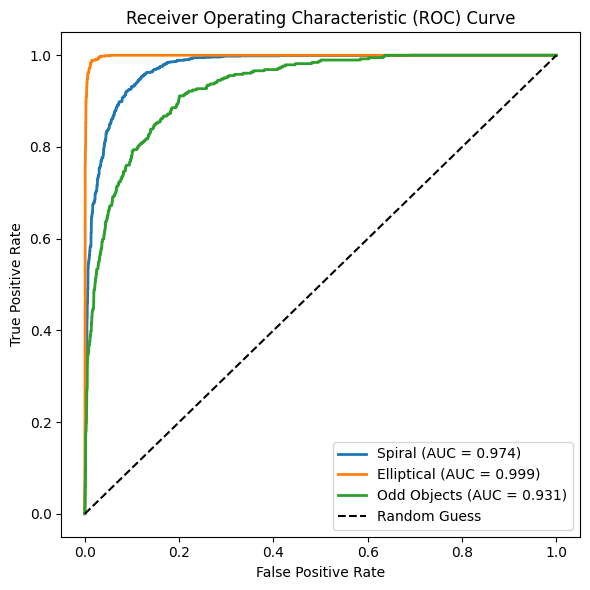

In [66]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd Objects']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e7))


# Save ROC curves
model_ii_roc_curves = []

for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_ii_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [67]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model II'] = model_ii_roc_curves

In [68]:
# Performance
# -----------------------------------------------------------------------------
# Note: There was a bug in the original code. They use y_pred instead of
# y_pred_labels.
# -----------------------------------------------------------------------------

recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

# Calculating the True Skill Score (TSS) for every class

# We need the confusion matrix for this
cm = confusion_matrix(y_test, y_pred_labels)

tss_per_class = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements

    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss

    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

TSS for 'Spiral' class: 0.7972276814960396
TSS for 'Elliptical' class: 0.9724897912138576
TSS for 'Odd Objects' class: 0.671074973876698


In [69]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

Recall: 0.8862397820163488
Precision: 0.9039194409457624
F1_score: 0.8917315164152382
Accuracy: 0.8862397820163488


## **Models III, IV, and V**: Three classifier models based on the original images

For these models, a Vision Transformer was used as a data augmentation tool on the Galaxy and Non-Galaxy images.

*Note: The additional dependencies needed for these models (like Torch) have already been imported at the beginning of this notebook.*

To read the images of each class and convert to Pillow images we used the following function (Ghaderi et al., 2025):

In [70]:
def load_galaxy_images(data_dir, target_size):
        """
        Loads, resizes, and processes all JPG images from the specified directory.

        Parameters:
        data_dir (str): The directory containing the JPG images to be processed.
        target_size (tuple): The target size for resizing the images, specified as (width, height).

        Returns:
        list: A list of PIL Image objects, each representing a resized and processed image.

        The function performs the following steps:
        1. Lists all JPG image files in the specified directory.
        2. Reads each image using OpenCV.
        3. Resizes each image to the specified target size.
        4. Scales the pixel values and converts the image to a format compatible with PIL.
        5. Converts each resized image to a PIL Image object.
        6. Appends each PIL Image object to a list.
        7. Returns the list of PIL Image objects.
        """

        all_images = []

        file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        for img in tqdm(file_path, desc="Processing images", unit="image"):
            image = cv2.imread(img)
            resized_images=cv2.resize(image, target_size)
            resized_images = (resized_images * 255).astype(np.uint8)
            pil_images = Image.fromarray(resized_images)
            all_images.append(pil_images)

        return all_images

The directoies of Spiral, Elliptical, Odd objectss images:

> Spiral: /repository/Data/galaxy/image/cropped_spiral
>
> Elliptical: /repository/Data/galaxy/image/cropped_elliptical
>
> Odd Objects: /repository/Data/galaxy/image/cropped_odd

In [71]:
# WARNING: This cell takes a while to run!
sp_dir = '/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_spiral'
el_dir = '/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_elliptical'
odd_dir = '/content/drive/Shared drives/DLP Project/Project/Data/galaxy/images/cropped_odd'

image_size = 200

sp_img = load_galaxy_images(sp_dir, target_size=(image_size,image_size))
el_img = load_galaxy_images(el_dir, target_size=(image_size,image_size))
odd_img = load_galaxy_images(odd_dir, target_size=(image_size,image_size))

Processing images: 100%|██████████| 1528/1528 [00:56<00:00, 27.00image/s] 


In [72]:
# Combining the data

# -----------------------------------------------------------------------------
# Note: There was a bug in the original code.
#
# all_data = np.concatenate([sp_img, el_img, odd_img])
# -----------------------------------------------------------------------------

# Here is the fix:
all_data = sp_img + el_img + odd_img
np.shape(all_data)

(11744, 200, 200, 3)

In [73]:
# Labels
label_s = [0] * len(sp_img)
label_e = [1] * len(el_img)
label_o = [2] * len(odd_img)

all_labels = label_s + label_e + label_o
len(all_labels)

11744

We define the **vision transformer** for both training and testing data sets:

In [74]:
# transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

### **Model III: CNN + Vision Transformer + Original Images**

In [75]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=50)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [76]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

In [77]:
# Defining the class weights to account for class imbalance
class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(odd_img))}

In [78]:
# Building the model

# input
x = Input(shape=(image_size,image_size,3))

#hidden layers
c0 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling2D(pool_size=(2, 2))(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling2D(pool_size=(2, 2))(b2)
d2 = Dropout(0.1)(m2)

f = Flatten()(m2)

de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(3, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_transformer_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 200, 200, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,940,035 (11.22 MB)

 Trainable params: 2,939,139 (11.21 MB)

 Non-trainable params: 896 (3.50 KB)

In [79]:
# Training the model
b_size = 64
e_num = 30

# Callback Functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
class_weight=class_weights,
callbacks=es,
validation_split=0.1)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 102s 622ms/step - accuracy: 0.5804 - loss: 1.8890 - val_accuracy: 0.6447 - val_loss: 0.8647
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 409ms/step - accuracy: 0.7949 - loss: 0.6553 - val_accuracy: 0.7072 - val_loss: 0.8299
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 50s 406ms/step - accuracy: 0.7997 - loss: 0.6240 - val_accuracy: 0.7389 - val_loss: 0.7516
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 411ms/step - accuracy: 0.8211 - loss: 0.5535 - val_accuracy: 0.5766 - val_loss: 1.5613
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 407ms/step - accuracy: 0.8316 - loss: 0.5352 - val_accuracy: 0.8331 - val_loss: 0.4961
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 409ms/step - accuracy: 0.8330 - loss: 0.5259 - val_accuracy: 0.7435 - val_loss: 0.6721
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 409ms/step - accuracy: 0.8564 - loss: 0.4747 - val_accuracy: 0.7355 - val_loss: 0.8853
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 410ms/step - accuracy: 0.8668 - loss: 

In [80]:
# Making predictions on unseen data (test set)
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step


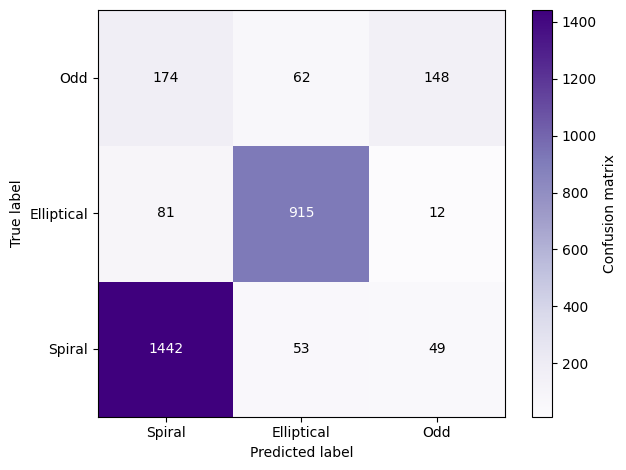

In [82]:
# Confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd']
plotting.plot_confusion_matrix(np.array(y_test), np.array(y_pred_labels), classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)
plt.savefig('CM_final3')

In [83]:
# Computing the ROC Curve
y_score = y_pred  # Use predicted probabilities for ROC curve

In [84]:
y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

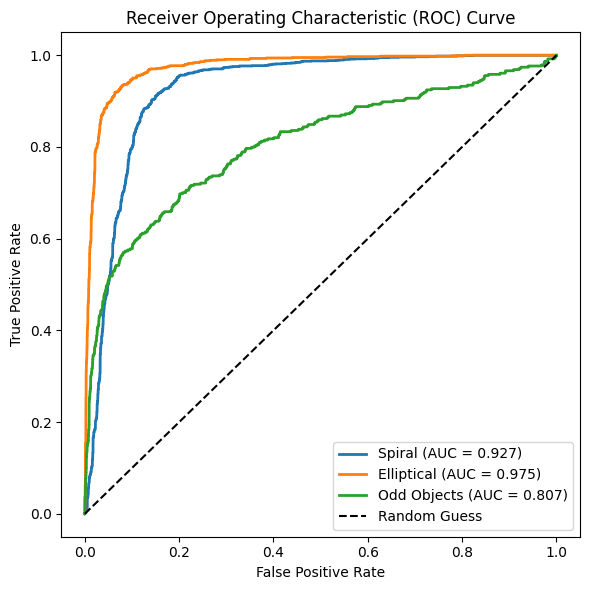

In [85]:
# Computing True Positive and False Positive Rates for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd Objects']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

mean_fpr = np.linspace(-float(1e-6), 1, int(1e7))

# Save ROC curves
model_iii_roc_curves = []

# Plotting the ROC curve for each class
for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_iii_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [86]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model III'] = model_iii_roc_curves

In [87]:
# Performance
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

# Calculating the True Skill Score (TSS) for every class

# We need the confusion matrix for this
cm = confusion_matrix(y_test, y_pred_labels)

tss_per_class = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements

    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss

    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

TSS for 'Spiral' class: 0.7507481686617831
TSS for 'Elliptical' class: 0.8480907923335309
TSS for 'Odd Objects' class: 0.36151384535005227


In [88]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

Recall: 0.8532016348773842
Precision: 0.844472182306752
F1_score: 0.8415277444670661
Accuracy: 0.8532016348773842


### **Model IV: ResNet50 + Vision transformer + Original Images**

In [89]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=50)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [90]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

In [91]:
# Defining the class weights to account for class imbalance
class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(odd_img))}

In [92]:
# Defining the pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # The custom layers
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [93]:
# Training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=es,
class_weight=class_weights,
validation_split=0.1
)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 165s 834ms/step - accuracy: 0.6507 - loss: 3.3176 - val_accuracy: 0.1237 - val_loss: 4.3516
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 65s 526ms/step - accuracy: 0.8736 - loss: 0.3498 - val_accuracy: 0.1237 - val_loss: 1.4444
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 65s 520ms/step - accuracy: 0.9090 - loss: 0.2539 - val_accuracy: 0.1237 - val_loss: 9.9346
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 518ms/step - accuracy: 0.8791 - loss: 0.3309 - val_accuracy: 0.2963 - val_loss: 1.5451
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 520ms/step - accuracy: 0.8932 - loss: 0.2420 - val_accuracy: 0.5040 - val_loss: 1.3908
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 65s 522ms/step - accuracy: 0.9304 - loss: 0.2106 - val_accuracy: 0.2826 - val_loss: 2.7249
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 65s 522ms/step - accuracy: 0.8972 - loss: 0.2622 - val_accuracy: 0.8173 - val_loss: 0.5974
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 65s 522ms/step - accuracy: 0.9090 - loss: 

In [94]:
# Making predictions on unseen data (test set)
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step


In [ ]:
# Confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd Objects']
plotting.plot_confusion_matrix(np.array(y_test), np.array(y_pred_labels), classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)
plt.savefig('CM_final4')

In [ ]:
# Plotting ROC curve

y_score = y_pred  # Use predicted probabilities for ROC curve
y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

# Computing True Positive and False Positive Rates for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd objects']

fig, ax = plt.subplots(figsize=(10, 8))

#mean_fpr = np.linspace(-float(1e-6), 1, int(1e6))
mean_fpr = np.linspace(-float(1e-6), 1, int(1e7))


# Save ROC curves
model_iv_roc_curves = []

# Plotting the ROC curve for each class
for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_iv_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model IV'] = model_iv_roc_curves

In [ ]:
# Performance
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

# Calculating the True Skill Score (TSS) for every class

# We need the confusion matrix for this
cm = confusion_matrix(y_test, y_pred_labels)

tss_per_class = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements

    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss

    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

### **Model V: VGG16 + Vision Transformer + Original Images**

In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=50)

y_train_encoded = to_categorical(y_train, num_classes=3)

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

In [ ]:
# Defining the class weights to account for class imbalance
class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(odd_img))}

In [ ]:
# Defining the pretrained VGG16
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # The custom layers
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=es,
class_weight=class_weights,
validation_split=0.1
)

In [ ]:
# Making predictions on unseen data (test set)
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
# Confusion matrix
classes = ['Spiral', 'Elliptical', 'Odd Objects']
plotting.plot_confusion_matrix(np.array(y_test), np.array(y_pred_labels), classes=classes, cmap=plt.cm.Purples, normalize=False, x_tick_rot=0)
plt.savefig('CM_final5')

In [ ]:
# Plotting ROC curve

y_score = y_pred  # Use predicted probabilities for ROC curve
y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_names = ['Spiral', 'Elliptical', 'Odd objects']

fig, ax = plt.subplots(figsize=(10, 8))

mean_fpr = np.linspace(-float(1e-6), 1, int(1e7))


# Save ROC curves
model_v_roc_curves = []

# Plotting the ROC curve for each class
for i in range(3):  # Iterate through each class
    tprs_interp = []
    for j in range(len(fpr)):
        tprs_interp.append(np.interp(mean_fpr, fpr[i], tpr[i]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    # Save curves to list
    model_v_roc_curves.append((mean_fpr, mean_tpr, mean_auc))

    ax.plot(mean_fpr, mean_tpr, label=f'{class_names[i]} (AUC = {mean_auc:.3f})', lw=2)

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model V'] = model_v_roc_curves

In [ ]:
# Performance
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

# Calculating the True Skill Score (TSS) for every class

# We need the confusion matrix for this
cm = confusion_matrix(y_test, y_pred_labels)

tss_per_class = {}

for i, class_name in enumerate(class_names):
    tp = cm[i, i]  # True Positives for class i
    fn = np.sum(cm[i, :]) - tp  # False Negatives: Sum of row minus TP
    fp = np.sum(cm[:, i]) - tp  # False Positives: Sum of column minus TP
    tn = np.sum(cm) - (tp + fn + fp)  # True Negatives: All other elements

    tss = (tp / (tp + fn)) - (fp / (fp + tn))  # True Skill Score for class i
    tss_per_class[class_name] = tss

    print("TSS for", f"'{class_name}'", "class:", tss_per_class[class_name])

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)

## **Model Comparisons**

In [ ]:
# ROC Curves for Spiral Galaxy
fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=100)

# Iterate over classes
classes = ['Spiral', 'Elliptical', 'Odd Objects']
for i, class_name in enumerate(classes):

  # Iterate over models
  for model_name in roc_curves:

    # Get the i-th class ROC curves of the current model
    class_roc_curves = roc_curves[model_name][i]

    # ROC curve data of i-th class by the current model
    mean_fpr = class_roc_curves[0]
    mean_tpr = class_roc_curves[1]
    mean_auc = class_roc_curves[2]

    ax[i].plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.3f})', lw=1)

  ax[i].plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')

  ax[i].set_title('ROC Curve - ' + f'{class_name}', fontsize=14)
  ax[i].legend(loc='lower right', fontsize=14)
  ax[i].set_xlabel('False Positive Rate', fontsize=14)
  ax[i].set_ylabel('True Positive Rate', fontsize=14)
  ax[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig('clean_final_1')
plt.show()